In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0706 15:54:50.585295 4759616960 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 32
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 1001

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 0)

In [12]:
phi_x_train[5]

array([ 0.70710678, -0.83146961, -0.55557023, ..., -0.98078528,
        0.70710678,  0.70710678])

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0706 15:54:51.936150 4759616960 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0706 15:54:51.937915 4759616960 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0706 15:54:51.991887 4759616960 feedforward_robust.py:40] Created placeholders for x and y
W0706 15:54:51.993459 4759616960 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0706 15:54:51.994371 4759616960 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0706 15:54:51.995246 4759616960 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0706 15:54:52.820015 4759616960 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.702841938 
I0706 15:54:53.281249 4759616960 feedforward_robust.py:751] Epoch: 0001    cost: 0.702841938 
Accuracy on batch: 0.531250
I0706 15:54:53.288533 4759616960 feedforward_robust.py:752] Accuracy on batch: 0.531250
Epoch: 0002    cost: 0.638768256 
I0706 15:54:53.436294 4759616960 feedforward_robust.py:751] Epoch: 0002    cost: 0.638768256 
Accuracy on batch: 0.656250
I0706 15:54:53.438776 4759616960 feedforward_robust.py:752] Accuracy on batch: 0.656250
Epoch: 0003    cost: 0.594060898 
I0706 15:54:53.535130 4759616960 feedforward_robust.py:751] Epoch: 0003    cost: 0.594060898 
Accuracy on batch: 0.781250
I0706 15:54:53.538297 4759616960 fe

Accuracy on batch: 1.000000
I0706 15:54:56.274730 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.210721076 
I0706 15:54:56.360143 4759616960 feedforward_robust.py:751] Epoch: 0034    cost: 0.210721076 
Accuracy on batch: 1.000000
I0706 15:54:56.362025 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.206123650 
I0706 15:54:56.450675 4759616960 feedforward_robust.py:751] Epoch: 0035    cost: 0.206123650 
Accuracy on batch: 1.000000
I0706 15:54:56.451877 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.201796174 
I0706 15:54:56.539297 4759616960 feedforward_robust.py:751] Epoch: 0036    cost: 0.201796174 
Accuracy on batch: 1.000000
I0706 15:54:56.540920 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.197795793 
I0706 15:54:56.625715 4759616960 feedforward_robust.py:751] Epoch: 0037    cost: 0.197795793 
Accuracy on batch: 1.000

I0706 15:54:59.292937 4759616960 feedforward_robust.py:751] Epoch: 0067    cost: 0.157720983 
Accuracy on batch: 1.000000
I0706 15:54:59.294419 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.157301545 
I0706 15:54:59.382383 4759616960 feedforward_robust.py:751] Epoch: 0068    cost: 0.157301545 
Accuracy on batch: 1.000000
I0706 15:54:59.384154 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.156941116 
I0706 15:54:59.483527 4759616960 feedforward_robust.py:751] Epoch: 0069    cost: 0.156941116 
Accuracy on batch: 1.000000
I0706 15:54:59.484874 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.156526625 
I0706 15:54:59.577201 4759616960 feedforward_robust.py:751] Epoch: 0070    cost: 0.156526625 
Accuracy on batch: 1.000000
I0706 15:54:59.578629 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.156162202 
I0706 15:54:59.653594 47

Epoch: 0101    cost: 0.141337097 
I0706 15:55:01.931137 4759616960 feedforward_robust.py:751] Epoch: 0101    cost: 0.141337097 
Accuracy on batch: 1.000000
I0706 15:55:01.933661 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.139080703 
I0706 15:55:02.013787 4759616960 feedforward_robust.py:751] Epoch: 0102    cost: 0.139080703 
Accuracy on batch: 1.000000
I0706 15:55:02.015279 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.137544885 
I0706 15:55:02.087316 4759616960 feedforward_robust.py:751] Epoch: 0103    cost: 0.137544885 
Accuracy on batch: 1.000000
I0706 15:55:02.089286 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.135988444 
I0706 15:55:02.160115 4759616960 feedforward_robust.py:751] Epoch: 0104    cost: 0.135988444 
Accuracy on batch: 1.000000
I0706 15:55:02.161540 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.1

I0706 15:55:04.723951 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.125002980 
I0706 15:55:04.830656 4759616960 feedforward_robust.py:751] Epoch: 0135    cost: 0.125002980 
Accuracy on batch: 1.000000
I0706 15:55:04.834202 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.124903940 
I0706 15:55:04.921664 4759616960 feedforward_robust.py:751] Epoch: 0136    cost: 0.124903940 
Accuracy on batch: 1.000000
I0706 15:55:04.923256 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.123362295 
I0706 15:55:05.006072 4759616960 feedforward_robust.py:751] Epoch: 0137    cost: 0.123362295 
Accuracy on batch: 1.000000
I0706 15:55:05.007742 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.120867699 
I0706 15:55:05.099272 4759616960 feedforward_robust.py:751] Epoch: 0138    cost: 0.120867699 
Accuracy on batch: 1.000000
I0706 15:55:05.103452 47

Accuracy on batch: 1.000000
I0706 15:55:08.209731 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.064418584 
I0706 15:55:08.320590 4759616960 feedforward_robust.py:751] Epoch: 0169    cost: 0.064418584 
Accuracy on batch: 1.000000
I0706 15:55:08.323077 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.064188547 
I0706 15:55:08.426476 4759616960 feedforward_robust.py:751] Epoch: 0170    cost: 0.064188547 
Accuracy on batch: 1.000000
I0706 15:55:08.427739 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.063984178 
I0706 15:55:08.514395 4759616960 feedforward_robust.py:751] Epoch: 0171    cost: 0.063984178 
Accuracy on batch: 1.000000
I0706 15:55:08.516346 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.063801922 
I0706 15:55:08.605959 4759616960 feedforward_robust.py:751] Epoch: 0172    cost: 0.063801922 
Accuracy on batch: 1.000

I0706 15:55:11.230279 4759616960 feedforward_robust.py:751] Epoch: 0202    cost: 0.024652662 
Accuracy on batch: 1.000000
I0706 15:55:11.231410 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.024113109 
I0706 15:55:11.300433 4759616960 feedforward_robust.py:751] Epoch: 0203    cost: 0.024113109 
Accuracy on batch: 1.000000
I0706 15:55:11.301595 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.023690937 
I0706 15:55:11.374917 4759616960 feedforward_robust.py:751] Epoch: 0204    cost: 0.023690937 
Accuracy on batch: 1.000000
I0706 15:55:11.376096 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.023339044 
I0706 15:55:11.457040 4759616960 feedforward_robust.py:751] Epoch: 0205    cost: 0.023339044 
Accuracy on batch: 1.000000
I0706 15:55:11.458133 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.023052074 
I0706 15:55:11.539227 47

Epoch: 0236    cost: 0.021191467 
I0706 15:55:14.012602 4759616960 feedforward_robust.py:751] Epoch: 0236    cost: 0.021191467 
Accuracy on batch: 1.000000
I0706 15:55:14.014735 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.021173669 
I0706 15:55:14.087600 4759616960 feedforward_robust.py:751] Epoch: 0237    cost: 0.021173669 
Accuracy on batch: 1.000000
I0706 15:55:14.089236 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.021156697 
I0706 15:55:14.160865 4759616960 feedforward_robust.py:751] Epoch: 0238    cost: 0.021156697 
Accuracy on batch: 1.000000
I0706 15:55:14.162595 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.021140210 
I0706 15:55:14.239417 4759616960 feedforward_robust.py:751] Epoch: 0239    cost: 0.021140210 
Accuracy on batch: 1.000000
I0706 15:55:14.241613 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0706 15:55:17.309114 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.020762021 
I0706 15:55:17.400613 4759616960 feedforward_robust.py:751] Epoch: 0270    cost: 0.020762021 
Accuracy on batch: 1.000000
I0706 15:55:17.403126 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.020752670 
I0706 15:55:17.482511 4759616960 feedforward_robust.py:751] Epoch: 0271    cost: 0.020752670 
Accuracy on batch: 1.000000
I0706 15:55:17.483898 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.020743424 
I0706 15:55:17.560985 4759616960 feedforward_robust.py:751] Epoch: 0272    cost: 0.020743424 
Accuracy on batch: 1.000000
I0706 15:55:17.562204 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.020734305 
I0706 15:55:17.649826 4759616960 feedforward_robust.py:751] Epoch: 0273    cost: 0.020734305 
Accuracy on batch: 1.000000
I0706 15:55:17.651022 47

Accuracy on batch: 1.000000
I0706 15:55:20.170328 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.020482641 
I0706 15:55:20.261531 4759616960 feedforward_robust.py:751] Epoch: 0304    cost: 0.020482641 
Accuracy on batch: 1.000000
I0706 15:55:20.264030 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.020475203 
I0706 15:55:20.344835 4759616960 feedforward_robust.py:751] Epoch: 0305    cost: 0.020475203 
Accuracy on batch: 1.000000
I0706 15:55:20.346117 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.020467866 
I0706 15:55:20.432852 4759616960 feedforward_robust.py:751] Epoch: 0306    cost: 0.020467866 
Accuracy on batch: 1.000000
I0706 15:55:20.434800 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.020460621 
I0706 15:55:20.516528 4759616960 feedforward_robust.py:751] Epoch: 0307    cost: 0.020460621 
Accuracy on batch: 1.000

I0706 15:55:22.742437 4759616960 feedforward_robust.py:751] Epoch: 0337    cost: 0.000998756 
Accuracy on batch: 1.000000
I0706 15:55:22.743519 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.000923833 
I0706 15:55:22.812751 4759616960 feedforward_robust.py:751] Epoch: 0338    cost: 0.000923833 
Accuracy on batch: 1.000000
I0706 15:55:22.813933 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.000864749 
I0706 15:55:22.883780 4759616960 feedforward_robust.py:751] Epoch: 0339    cost: 0.000864749 
Accuracy on batch: 1.000000
I0706 15:55:22.884986 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.000817554 
I0706 15:55:22.955343 4759616960 feedforward_robust.py:751] Epoch: 0340    cost: 0.000817554 
Accuracy on batch: 1.000000
I0706 15:55:22.956484 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.000779301 
I0706 15:55:23.026026 47

Epoch: 0371    cost: 0.000497975 
I0706 15:55:25.507431 4759616960 feedforward_robust.py:751] Epoch: 0371    cost: 0.000497975 
Accuracy on batch: 1.000000
I0706 15:55:25.512306 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.000494212 
I0706 15:55:25.596381 4759616960 feedforward_robust.py:751] Epoch: 0372    cost: 0.000494212 
Accuracy on batch: 1.000000
I0706 15:55:25.597697 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.000490571 
I0706 15:55:25.675796 4759616960 feedforward_robust.py:751] Epoch: 0373    cost: 0.000490571 
Accuracy on batch: 1.000000
I0706 15:55:25.677950 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.000486990 
I0706 15:55:25.754673 4759616960 feedforward_robust.py:751] Epoch: 0374    cost: 0.000486990 
Accuracy on batch: 1.000000
I0706 15:55:25.756313 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0706 15:55:28.555049 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.000401030 
I0706 15:55:28.672228 4759616960 feedforward_robust.py:751] Epoch: 0405    cost: 0.000401030 
Accuracy on batch: 1.000000
I0706 15:55:28.674725 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.000398744 
I0706 15:55:28.805320 4759616960 feedforward_robust.py:751] Epoch: 0406    cost: 0.000398744 
Accuracy on batch: 1.000000
I0706 15:55:28.822099 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.000396517 
I0706 15:55:28.919564 4759616960 feedforward_robust.py:751] Epoch: 0407    cost: 0.000396517 
Accuracy on batch: 1.000000
I0706 15:55:28.921637 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.000394339 
I0706 15:55:29.013015 4759616960 feedforward_robust.py:751] Epoch: 0408    cost: 0.000394339 
Accuracy on batch: 1.000000
I0706 15:55:29.014384 47

Accuracy on batch: 1.000000
I0706 15:55:31.835512 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.000335904 
I0706 15:55:31.908200 4759616960 feedforward_robust.py:751] Epoch: 0439    cost: 0.000335904 
Accuracy on batch: 1.000000
I0706 15:55:31.910086 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.000334251 
I0706 15:55:31.992424 4759616960 feedforward_robust.py:751] Epoch: 0440    cost: 0.000334251 
Accuracy on batch: 1.000000
I0706 15:55:31.993685 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.000332631 
I0706 15:55:32.077581 4759616960 feedforward_robust.py:751] Epoch: 0441    cost: 0.000332631 
Accuracy on batch: 1.000000
I0706 15:55:32.078714 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.000331008 
I0706 15:55:32.161365 4759616960 feedforward_robust.py:751] Epoch: 0442    cost: 0.000331008 
Accuracy on batch: 1.000

I0706 15:55:34.641925 4759616960 feedforward_robust.py:751] Epoch: 0472    cost: 0.000287475 
Accuracy on batch: 1.000000
I0706 15:55:34.643616 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.000286134 
I0706 15:55:34.739848 4759616960 feedforward_robust.py:751] Epoch: 0473    cost: 0.000286134 
Accuracy on batch: 1.000000
I0706 15:55:34.741618 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.000284801 
I0706 15:55:34.815659 4759616960 feedforward_robust.py:751] Epoch: 0474    cost: 0.000284801 
Accuracy on batch: 1.000000
I0706 15:55:34.816988 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.000283464 
I0706 15:55:34.889054 4759616960 feedforward_robust.py:751] Epoch: 0475    cost: 0.000283464 
Accuracy on batch: 1.000000
I0706 15:55:34.890201 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.000282131 
I0706 15:55:34.961371 47

Epoch: 0506    cost: 0.000245779 
I0706 15:55:37.495126 4759616960 feedforward_robust.py:751] Epoch: 0506    cost: 0.000245779 
Accuracy on batch: 1.000000
I0706 15:55:37.496329 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.000244702 
I0706 15:55:37.572432 4759616960 feedforward_robust.py:751] Epoch: 0507    cost: 0.000244702 
Accuracy on batch: 1.000000
I0706 15:55:37.573914 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.000243615 
I0706 15:55:37.653692 4759616960 feedforward_robust.py:751] Epoch: 0508    cost: 0.000243615 
Accuracy on batch: 1.000000
I0706 15:55:37.655154 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.000242550 
I0706 15:55:37.725224 4759616960 feedforward_robust.py:751] Epoch: 0509    cost: 0.000242550 
Accuracy on batch: 1.000000
I0706 15:55:37.726687 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0706 15:55:40.046647 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.000213014 
I0706 15:55:40.119542 4759616960 feedforward_robust.py:751] Epoch: 0540    cost: 0.000213014 
Accuracy on batch: 1.000000
I0706 15:55:40.120655 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.000212158 
I0706 15:55:40.189510 4759616960 feedforward_robust.py:751] Epoch: 0541    cost: 0.000212158 
Accuracy on batch: 1.000000
I0706 15:55:40.190627 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.000211316 
I0706 15:55:40.260061 4759616960 feedforward_robust.py:751] Epoch: 0542    cost: 0.000211316 
Accuracy on batch: 1.000000
I0706 15:55:40.261125 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.000210478 
I0706 15:55:40.336934 4759616960 feedforward_robust.py:751] Epoch: 0543    cost: 0.000210478 
Accuracy on batch: 1.000000
I0706 15:55:40.338082 47

Accuracy on batch: 1.000000
I0706 15:55:42.636501 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.000187149 
I0706 15:55:42.706184 4759616960 feedforward_robust.py:751] Epoch: 0574    cost: 0.000187149 
Accuracy on batch: 1.000000
I0706 15:55:42.707338 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.000186457 
I0706 15:55:42.776770 4759616960 feedforward_robust.py:751] Epoch: 0575    cost: 0.000186457 
Accuracy on batch: 1.000000
I0706 15:55:42.777912 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.000185775 
I0706 15:55:42.851729 4759616960 feedforward_robust.py:751] Epoch: 0576    cost: 0.000185775 
Accuracy on batch: 1.000000
I0706 15:55:42.853343 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.000185090 
I0706 15:55:42.928631 4759616960 feedforward_robust.py:751] Epoch: 0577    cost: 0.000185090 
Accuracy on batch: 1.000

I0706 15:55:45.325900 4759616960 feedforward_robust.py:751] Epoch: 0607    cost: 0.000165947 
Accuracy on batch: 1.000000
I0706 15:55:45.328862 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.000165343 
I0706 15:55:45.427155 4759616960 feedforward_robust.py:751] Epoch: 0608    cost: 0.000165343 
Accuracy on batch: 1.000000
I0706 15:55:45.429633 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.000164714 
I0706 15:55:45.567589 4759616960 feedforward_robust.py:751] Epoch: 0609    cost: 0.000164714 
Accuracy on batch: 1.000000
I0706 15:55:45.582896 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.000164095 
I0706 15:55:45.681267 4759616960 feedforward_robust.py:751] Epoch: 0610    cost: 0.000164095 
Accuracy on batch: 1.000000
I0706 15:55:45.683520 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.000163481 
I0706 15:55:45.775952 47

Epoch: 0641    cost: 0.000146479 
I0706 15:55:49.188623 4759616960 feedforward_robust.py:751] Epoch: 0641    cost: 0.000146479 
Accuracy on batch: 1.000000
I0706 15:55:49.191174 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000145957 
I0706 15:55:49.295693 4759616960 feedforward_robust.py:751] Epoch: 0642    cost: 0.000145957 
Accuracy on batch: 1.000000
I0706 15:55:49.297292 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000145451 
I0706 15:55:49.429468 4759616960 feedforward_robust.py:751] Epoch: 0643    cost: 0.000145451 
Accuracy on batch: 1.000000
I0706 15:55:49.458629 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000144941 
I0706 15:55:49.571494 4759616960 feedforward_robust.py:751] Epoch: 0644    cost: 0.000144941 
Accuracy on batch: 1.000000
I0706 15:55:49.572912 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0706 15:55:52.721860 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000130422 
I0706 15:55:52.817069 4759616960 feedforward_robust.py:751] Epoch: 0675    cost: 0.000130422 
Accuracy on batch: 1.000000
I0706 15:55:52.822335 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000129975 
I0706 15:55:52.944476 4759616960 feedforward_robust.py:751] Epoch: 0676    cost: 0.000129975 
Accuracy on batch: 1.000000
I0706 15:55:52.945864 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000129554 
I0706 15:55:53.047059 4759616960 feedforward_robust.py:751] Epoch: 0677    cost: 0.000129554 
Accuracy on batch: 1.000000
I0706 15:55:53.048793 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000129137 
I0706 15:55:53.137181 4759616960 feedforward_robust.py:751] Epoch: 0678    cost: 0.000129137 
Accuracy on batch: 1.000000
I0706 15:55:53.138685 47

Accuracy on batch: 1.000000
I0706 15:55:55.983229 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000117065 
I0706 15:55:56.064256 4759616960 feedforward_robust.py:751] Epoch: 0709    cost: 0.000117065 
Accuracy on batch: 1.000000
I0706 15:55:56.065623 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000116700 
I0706 15:55:56.146843 4759616960 feedforward_robust.py:751] Epoch: 0710    cost: 0.000116700 
Accuracy on batch: 1.000000
I0706 15:55:56.149492 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000116339 
I0706 15:55:56.238116 4759616960 feedforward_robust.py:751] Epoch: 0711    cost: 0.000116339 
Accuracy on batch: 1.000000
I0706 15:55:56.241049 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000115996 
I0706 15:55:56.335662 4759616960 feedforward_robust.py:751] Epoch: 0712    cost: 0.000115996 
Accuracy on batch: 1.000

I0706 15:55:59.252521 4759616960 feedforward_robust.py:751] Epoch: 0742    cost: 0.000106156 
Accuracy on batch: 1.000000
I0706 15:55:59.254348 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000105850 
I0706 15:55:59.344590 4759616960 feedforward_robust.py:751] Epoch: 0743    cost: 0.000105850 
Accuracy on batch: 1.000000
I0706 15:55:59.346598 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000105537 
I0706 15:55:59.441440 4759616960 feedforward_robust.py:751] Epoch: 0744    cost: 0.000105537 
Accuracy on batch: 1.000000
I0706 15:55:59.443174 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000105239 
I0706 15:55:59.530488 4759616960 feedforward_robust.py:751] Epoch: 0745    cost: 0.000105239 
Accuracy on batch: 1.000000
I0706 15:55:59.531861 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000104945 
I0706 15:55:59.632863 47

Epoch: 0776    cost: 0.000096542 
I0706 15:56:02.785582 4759616960 feedforward_robust.py:751] Epoch: 0776    cost: 0.000096542 
Accuracy on batch: 1.000000
I0706 15:56:02.787188 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000096274 
I0706 15:56:02.864535 4759616960 feedforward_robust.py:751] Epoch: 0777    cost: 0.000096274 
Accuracy on batch: 1.000000
I0706 15:56:02.866020 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000096013 
I0706 15:56:02.942778 4759616960 feedforward_robust.py:751] Epoch: 0778    cost: 0.000096013 
Accuracy on batch: 1.000000
I0706 15:56:02.944153 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000095764 
I0706 15:56:03.017605 4759616960 feedforward_robust.py:751] Epoch: 0779    cost: 0.000095764 
Accuracy on batch: 1.000000
I0706 15:56:03.019089 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0706 15:56:06.371732 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000088266 
I0706 15:56:06.470329 4759616960 feedforward_robust.py:751] Epoch: 0810    cost: 0.000088266 
Accuracy on batch: 1.000000
I0706 15:56:06.473264 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000088050 
I0706 15:56:06.565850 4759616960 feedforward_robust.py:751] Epoch: 0811    cost: 0.000088050 
Accuracy on batch: 1.000000
I0706 15:56:06.567178 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000087826 
I0706 15:56:06.645555 4759616960 feedforward_robust.py:751] Epoch: 0812    cost: 0.000087826 
Accuracy on batch: 1.000000
I0706 15:56:06.647826 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000087603 
I0706 15:56:06.739675 4759616960 feedforward_robust.py:751] Epoch: 0813    cost: 0.000087603 
Accuracy on batch: 1.000000
I0706 15:56:06.743514 47

Accuracy on batch: 1.000000
I0706 15:56:09.839065 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000081088 
I0706 15:56:10.013291 4759616960 feedforward_robust.py:751] Epoch: 0844    cost: 0.000081088 
Accuracy on batch: 1.000000
I0706 15:56:10.022564 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000080890 
I0706 15:56:10.186575 4759616960 feedforward_robust.py:751] Epoch: 0845    cost: 0.000080890 
Accuracy on batch: 1.000000
I0706 15:56:10.205551 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000080693 
I0706 15:56:10.365563 4759616960 feedforward_robust.py:751] Epoch: 0846    cost: 0.000080693 
Accuracy on batch: 1.000000
I0706 15:56:10.368966 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000080492 
I0706 15:56:10.501253 4759616960 feedforward_robust.py:751] Epoch: 0847    cost: 0.000080492 
Accuracy on batch: 1.000

I0706 15:56:14.883440 4759616960 feedforward_robust.py:751] Epoch: 0877    cost: 0.000074930 
Accuracy on batch: 1.000000
I0706 15:56:14.886951 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000074752 
I0706 15:56:14.997874 4759616960 feedforward_robust.py:751] Epoch: 0878    cost: 0.000074752 
Accuracy on batch: 1.000000
I0706 15:56:14.999282 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000074592 
I0706 15:56:15.123795 4759616960 feedforward_robust.py:751] Epoch: 0879    cost: 0.000074592 
Accuracy on batch: 1.000000
I0706 15:56:15.135696 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000074409 
I0706 15:56:15.307966 4759616960 feedforward_robust.py:751] Epoch: 0880    cost: 0.000074409 
Accuracy on batch: 1.000000
I0706 15:56:15.316936 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000074234 
I0706 15:56:15.412363 47

Epoch: 0911    cost: 0.000069332 
I0706 15:56:19.901047 4759616960 feedforward_robust.py:751] Epoch: 0911    cost: 0.000069332 
Accuracy on batch: 1.000000
I0706 15:56:19.909962 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000069175 
I0706 15:56:20.075917 4759616960 feedforward_robust.py:751] Epoch: 0912    cost: 0.000069175 
Accuracy on batch: 1.000000
I0706 15:56:20.083616 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000069030 
I0706 15:56:20.223426 4759616960 feedforward_robust.py:751] Epoch: 0913    cost: 0.000069030 
Accuracy on batch: 1.000000
I0706 15:56:20.227147 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000068863 
I0706 15:56:20.384330 4759616960 feedforward_robust.py:751] Epoch: 0914    cost: 0.000068863 
Accuracy on batch: 1.000000
I0706 15:56:20.388055 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0706 15:56:24.642106 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000064352 
I0706 15:56:24.771720 4759616960 feedforward_robust.py:751] Epoch: 0945    cost: 0.000064352 
Accuracy on batch: 1.000000
I0706 15:56:24.777901 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000064214 
I0706 15:56:24.884591 4759616960 feedforward_robust.py:751] Epoch: 0946    cost: 0.000064214 
Accuracy on batch: 1.000000
I0706 15:56:24.886906 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000064069 
I0706 15:56:25.033521 4759616960 feedforward_robust.py:751] Epoch: 0947    cost: 0.000064069 
Accuracy on batch: 1.000000
I0706 15:56:25.039226 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000063934 
I0706 15:56:25.153168 4759616960 feedforward_robust.py:751] Epoch: 0948    cost: 0.000063934 
Accuracy on batch: 1.000000
I0706 15:56:25.158362 47

Accuracy on batch: 1.000000
I0706 15:56:30.221370 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000059897 
I0706 15:56:30.374835 4759616960 feedforward_robust.py:751] Epoch: 0979    cost: 0.000059897 
Accuracy on batch: 1.000000
I0706 15:56:30.376595 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000059755 
I0706 15:56:30.492825 4759616960 feedforward_robust.py:751] Epoch: 0980    cost: 0.000059755 
Accuracy on batch: 1.000000
I0706 15:56:30.497077 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000059643 
I0706 15:56:30.639973 4759616960 feedforward_robust.py:751] Epoch: 0981    cost: 0.000059643 
Accuracy on batch: 1.000000
I0706 15:56:30.642024 4759616960 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000059517 
I0706 15:56:30.801620 4759616960 feedforward_robust.py:751] Epoch: 0982    cost: 0.000059517 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(0.86438704, 0.5314)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 5)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.33968216, 0.33331144, 0.33064273, 0.3294708 , 0.3299718 ,
       0.33171183, 0.3347238 , 0.3390272 , 0.34441146, 0.35128635,
       0.35907105, 0.36703545, 0.37602308, 0.38597178, 0.39672318,
       0.40822047, 0.42024824, 0.43250048, 0.44465846, 0.4567354 ,
       0.46897256, 0.48167777, 0.4947871 , 0.5083986 , 0.5222577 ,
       0.5360588 , 0.5489481 , 0.56173295, 0.57375115, 0.5858066 ,
       0.59778035, 0.6097125 , 0.62161493, 0.6334654 , 0.6453617 ,
       0.657112  , 0.66864973, 0.67998505, 0.691146  , 0.7019427 ,
       0.7124216 , 0.7217797 , 0.73120964, 0.74065816, 0.749995  ,
       0.7590369 , 0.7677155 , 0.77562267, 0.783193  , 0.79046583,
       0.7975162 , 0.80384386, 0.81010854, 0.81636953, 0.82256174,
       0.82845247, 0.83413124, 0.83964396, 0.84498066, 0.8501201 ,
       0.8543801 , 0.85861677, 0.8628132 , 0.8668081 , 0.87084025,
       0.8748889 , 0.878909  , 0.8829312 , 0.88626885, 0.8895625 ,
       0.8927543 , 0.8958007 , 0.8986348 , 0.9013181 , 0.90404

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(32, 1)

In [29]:
y_train_ogi.shape

(32, 1)

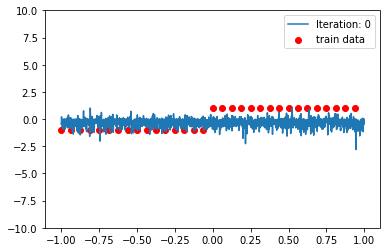

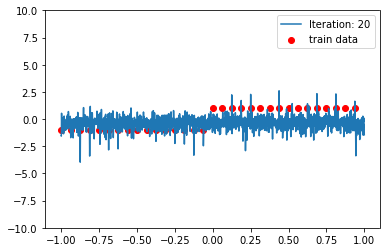

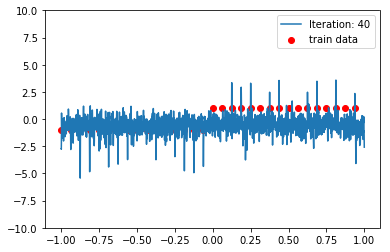

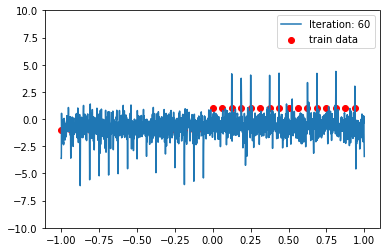

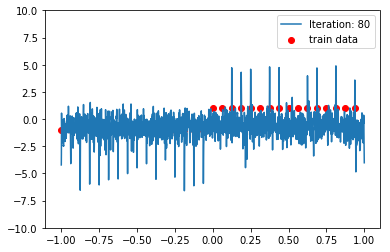

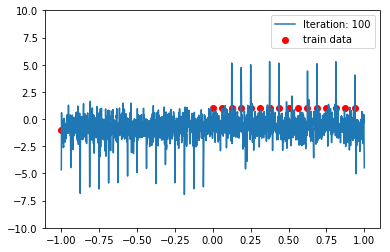

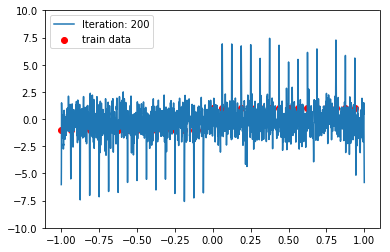

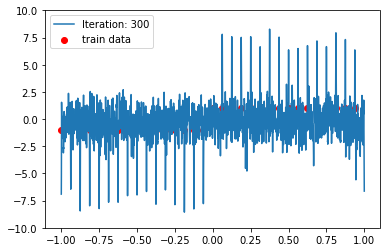

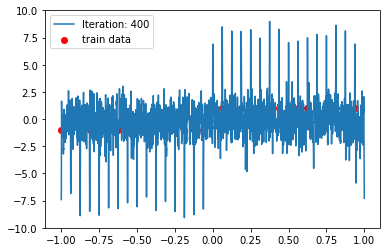

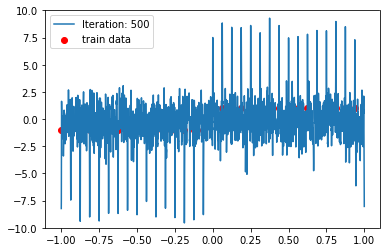

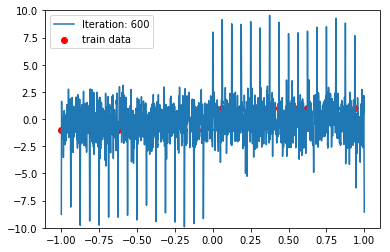

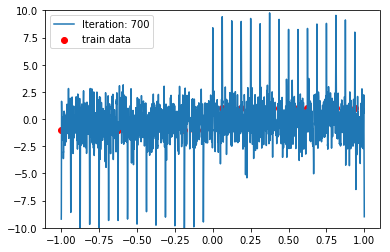

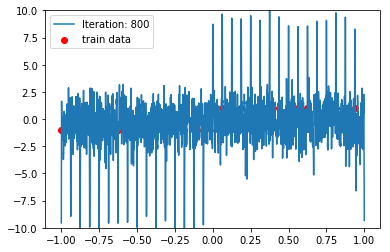

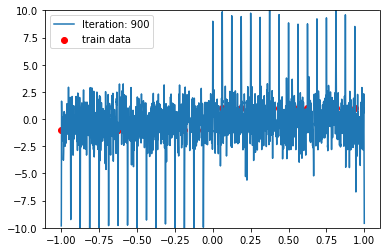

In [30]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-1]

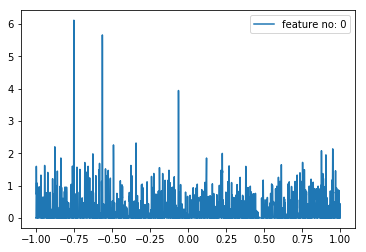

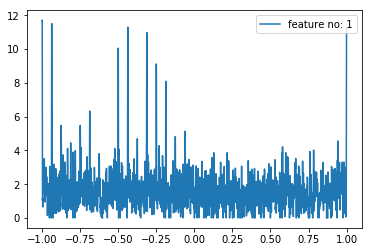

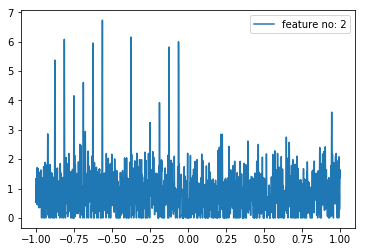

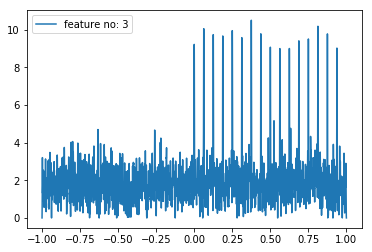

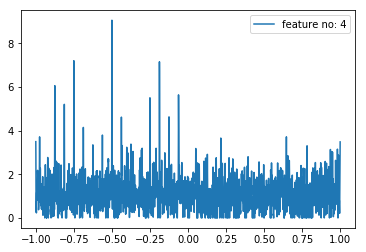

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()